In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/earthpulse/pytorch_eo/blob/master/examples/ucmerced.ipynb)

In this example we are going to train an image classifier with the [UCMerced](http://weegee.vision.ucmerced.edu/datasets/landuse.html) dataset.

In [23]:
from pytorch_eo.datasets import UCMercedLandUse

ds = UCMercedLandUse(batch_size=25, verbose=True) 

ds.setup()

data already extracted !
Number of images: 2100
Training samples 1260
Validation samples 420
Test samples 420


In [24]:
ds.df

,image,label
0,data/UCMerced_LandUse/Images/agricultural/agri...,0
1,data/UCMerced_LandUse/Images/agricultural/agri...,0
2,data/UCMerced_LandUse/Images/agricultural/agri...,0
3,data/UCMerced_LandUse/Images/agricultural/agri...,0
4,data/UCMerced_LandUse/Images/agricultural/agri...,0
...,...,...
2095,data/UCMerced_LandUse/Images/tenniscourt/tenni...,20
2096,data/UCMerced_LandUse/Images/tenniscourt/tenni...,20
2097,data/UCMerced_LandUse/Images/tenniscourt/tenni...,20
2098,data/UCMerced_LandUse/Images/tenniscourt/tenni...,20


In [25]:
ds.num_classes, ds.classes

(21,
 ['agricultural',
  'airplane',
  'baseballdiamond',
  'beach',
  'buildings',
  'chaparral',
  'denseresidential',
  'forest',
  'freeway',
  'golfcourse',
  'harbor',
  'intersection',
  'mediumresidential',
  'mobilehomepark',
  'overpass',
  'parkinglot',
  'river',
  'runway',
  'sparseresidential',
  'storagetanks',
  'tenniscourt'])

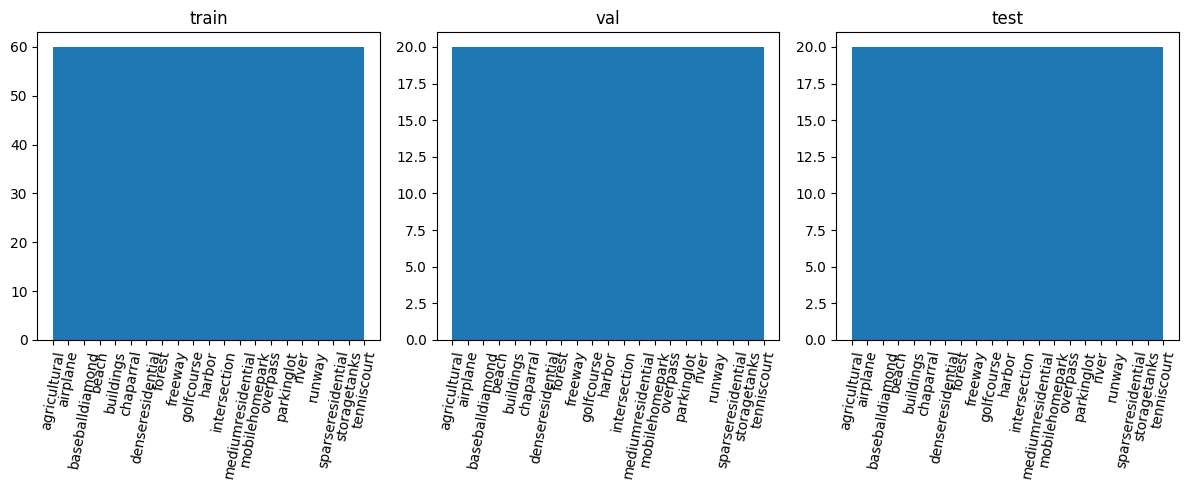

In [26]:
# label distribution

import numpy as np 
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))
ax = plt.subplot(1,3,1)
ax.hist(ds.train_df.label, bins=len(ds.classes))
ax.set_title('train')
ax.set_xticks(list(range(len(ds.classes))))
ax.set_xticklabels(ds.classes, rotation=80)
ax = plt.subplot(1,3,2)
ax.hist(ds.val_df.label, bins=len(ds.classes))
ax.set_title('val')
ax.set_xticks(list(range(len(ds.classes))))
ax.set_xticklabels(ds.classes, rotation=80)
ax = plt.subplot(1,3,3)
ax.hist(ds.test_df.label, bins=len(ds.classes))
ax.set_title('test')
ax.set_xticks(list(range(len(ds.classes))))
ax.set_xticklabels(ds.classes, rotation=80)
plt.tight_layout()
plt.show()

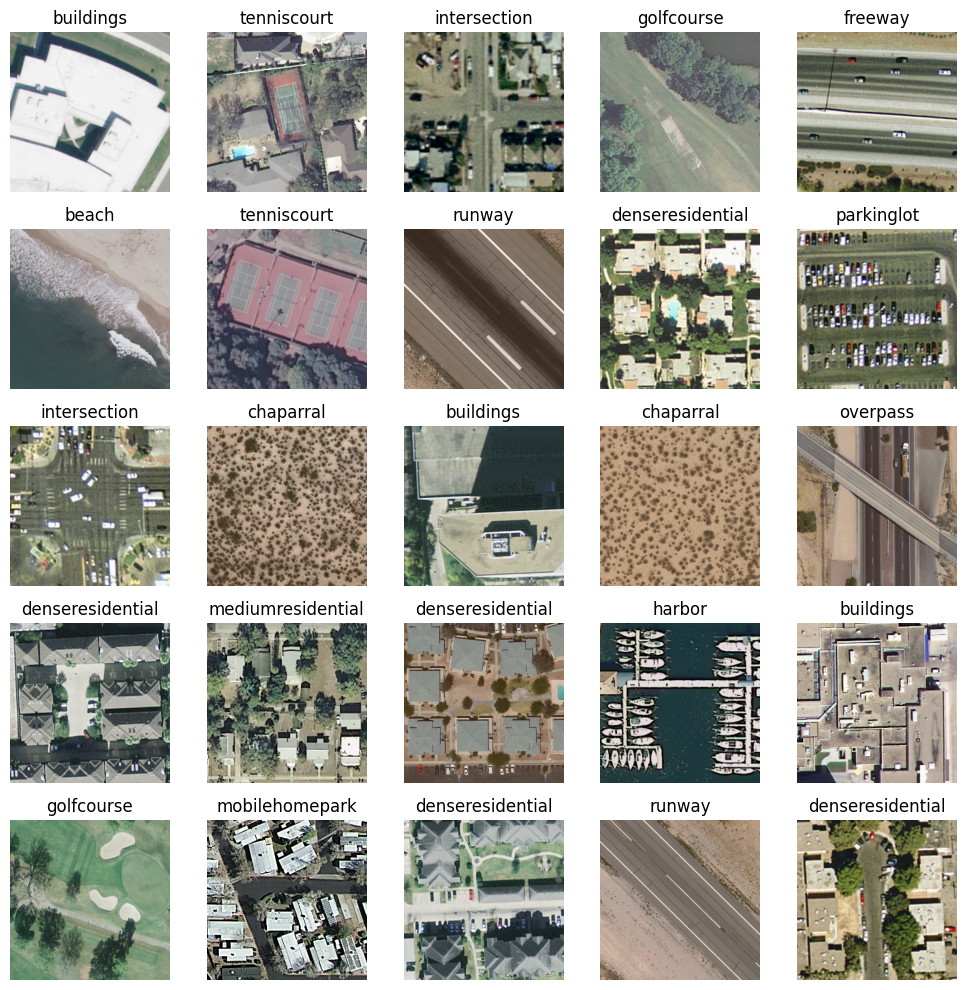

In [27]:
import matplotlib.pyplot as plt

batch = next(iter(ds.train_dataloader()))
imgs, labels = batch['image'], batch['label']

fig = plt.figure(figsize=(10, 10))
th = 4000
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    ax.imshow(img)
    ax.set_title(ds.classes[label.item()])
    ax.axis('off')
plt.tight_layout()
plt.show()

Images are RGB with 256x256 pixels (although some have a different size, we'll need to fix it).

In [28]:
img.shape, img.dtype, img.min(), img.max()

(torch.Size([256, 256, 3]),
 torch.uint8,
 tensor(13, dtype=torch.uint8),
 tensor(250, dtype=torch.uint8))

Training

In [29]:
import lightning as L
from pytorch_eo.tasks.classification import ImageClassification
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_trans = A.Compose([
    A.RandomCrop(224, 224),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Transpose(),
    A.Normalize(0, 1),    
    ToTensorV2()                                
])

val_test_trans = A.Compose([
    A.CenterCrop(224, 224),
    A.Normalize(0, 1),    
    ToTensorV2()                                
])

ds = UCMercedLandUse(batch_size=64, train_trans=train_trans, val_trans=val_test_trans, test_trans=val_test_trans, num_workers=4, pin_memory=True)

task = ImageClassification(num_classes=ds.num_classes)

In [30]:
trainer = L.Trainer(
    devices=1,
    accelerator='cuda',
    max_epochs=10,
    log_every_n_steps=10
)

trainer.fit(task, ds)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type               | Params
-----------------------------------------------
0 | model   | ResNet             | 11.2 M
1 | loss_fn | CrossEntropyLoss   | 0     
2 | acc     | MulticlassAccuracy | 0     
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.749    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [33]:
trainer.test(dataloaders=ds.test_dataloader())

/home/juan/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at /home/juan/Desktop/pytorch_eo/examples/lightning_logs/version_11/checkpoints/epoch=9-step=200.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the c

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3690476417541504     │
│         test_loss         │    2.9636316299438477     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.9636316299438477, 'test_acc': 0.3690476417541504}]